# AI Customer Message Classifier
This notebook demonstrates an applied AI integration workflow that classifies and routes customer or tenant messages automatically.


In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
import duckdb
from openai import OpenAI
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json

# --- Load Environment ---
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
print("✅ Environment and API loaded.")


✅ Environment and API loaded.


In [4]:
# --- Generate Synthetic Customer Messages ---
messages = [
    ("My sink is leaking again, please send maintenance.", "Maintenance"),
    ("Can I renew my lease early?", "Leasing"),
    ("When is rent due this month?", "Billing"),
    ("The parking gate won't open with my code.", "Maintenance"),
    ("How can I set up autopay for my rent?", "Billing"),
    ("My air conditioner stopped working.", "Maintenance"),
    ("I lost my mailbox key, what should I do?", "General Inquiry"),
    ("I'd like to transfer to another unit when available.", "Leasing"),
    ("Can I get a copy of my last payment receipt?", "Billing"),
    ("Who do I contact about noise complaints?", "General Inquiry")
]

df = pd.DataFrame(messages, columns=["message_text", "true_category"])
df.to_csv("data/synthetic_messages.csv", index=False)
print("✅ Synthetic dataset created with", len(df), "messages.")
df.head()


✅ Synthetic dataset created with 10 messages.


,message_text,true_category
0,"My sink is leaking again, please send maintena...",Maintenance
1,Can I renew my lease early?,Leasing
2,When is rent due this month?,Billing
3,The parking gate won't open with my code.,Maintenance
4,How can I set up autopay for my rent?,Billing


In [5]:
# --- Define LLM-based classifier ---
def classify_message(message_text):
    prompt = f"""
    Classify the following message into one of these categories:
    [Maintenance, Billing, Leasing, General Inquiry].
    Message: "{message_text}"
    Respond only with the category name.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("Error:", e)
        return "Error"


In [7]:
df["predicted_category"] = df["message_text"].apply(classify_message)
df.to_csv("data/classified_messages.csv", index=False)
print("✅ Classification complete.")
df.head()


✅ Classification complete.


,message_text,true_category,predicted_category
0,"My sink is leaking again, please send maintena...",Maintenance,Maintenance
1,Can I renew my lease early?,Leasing,Leasing
2,When is rent due this month?,Billing,Billing
3,The parking gate won't open with my code.,Maintenance,Maintenance
4,How can I set up autopay for my rent?,Billing,Billing


Classification Report:
                 precision  recall  f1-score  support
Billing                1.0     1.0       1.0      3.0
General Inquiry        1.0     1.0       1.0      2.0
Leasing                1.0     1.0       1.0      2.0
Maintenance            1.0     1.0       1.0      3.0
accuracy               1.0     1.0       1.0      1.0
macro avg              1.0     1.0       1.0     10.0
weighted avg           1.0     1.0       1.0     10.0


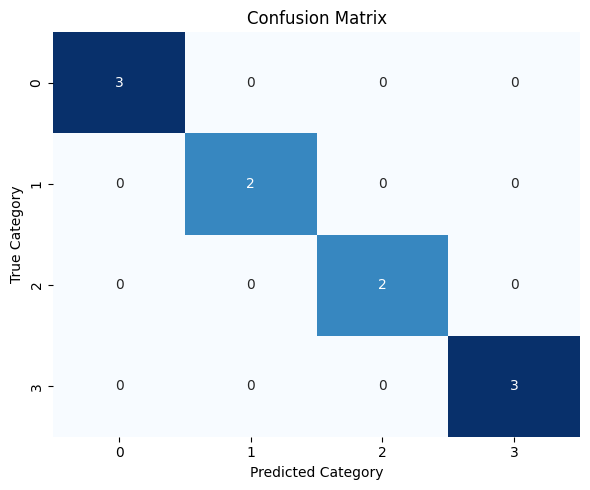

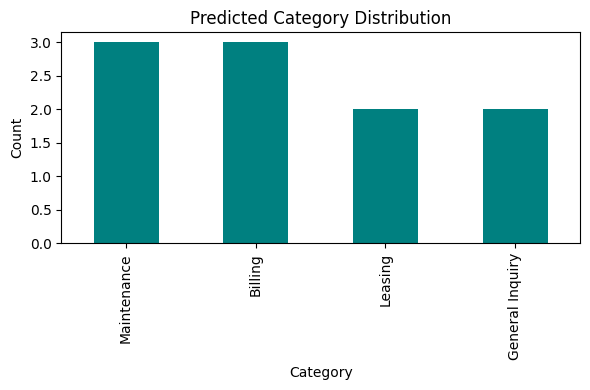

✅ Visualizations and metrics saved to the 'figures/' directory.


In [9]:
# --- Evaluate Model Accuracy and Save Visualizations ---

import os
os.makedirs("figures", exist_ok=True)  # ensure folder exists

# Classification metrics
report = classification_report(df["true_category"], df["predicted_category"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

# Save metrics to CSV for reference
report_df.to_csv("figures/classification_report.csv")

# Confusion matrix plot
cm = confusion_matrix(df["true_category"], df["predicted_category"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.tight_layout()

# Save and show
plt.savefig("figures/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Bar chart of predictions
plt.figure(figsize=(6, 4))
df["predicted_category"].value_counts().plot(kind="bar", color="teal")
plt.title("Predicted Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/predicted_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Visualizations and metrics saved to the 'figures/' directory.")



In [10]:
# --- Save classification results into DuckDB database ---

import duckdb
import os

# Ensure database folder exists
os.makedirs("data", exist_ok=True)

db_path = "data/classified_messages.duckdb"

# Connect (creates file if not present)
con = duckdb.connect(database=db_path)

# Write or replace the table
con.execute("CREATE OR REPLACE TABLE messages AS SELECT * FROM df")

# Verify storage
row_count = con.execute("SELECT COUNT(*) FROM messages").fetchone()[0]
sample = con.execute("SELECT * FROM messages LIMIT 5").fetchdf()

con.close()

print(f"✅ Stored {row_count} classified messages in '{db_path}'.")
print("Preview of stored data:")
display(sample)


✅ Stored 10 classified messages in 'data/classified_messages.duckdb'.
Preview of stored data:


,message_text,true_category,predicted_category
0,"My sink is leaking again, please send maintena...",Maintenance,Maintenance
1,Can I renew my lease early?,Leasing,Leasing
2,When is rent due this month?,Billing,Billing
3,The parking gate won't open with my code.,Maintenance,Maintenance
4,How can I set up autopay for my rent?,Billing,Billing


## 🧠 Summary and Next Steps

This notebook demonstrates a practical AI-integration workflow for automatically classifying
customer or tenant messages into operational categories such as **Maintenance**, **Billing**,
**Leasing**, and **General Inquiry**.

**Key outcomes**
- Generated a reproducible synthetic dataset for message classification.
- Applied an LLM-based classifier (OpenAI GPT-4o mini) to categorize text messages.
- Evaluated performance with precision, recall, F1-score, and a confusion matrix.
- Stored all results in a persistent **DuckDB** database for downstream analysis.
- Saved metrics and visualizations to the `figures/` directory for easy versioning.

**Next steps**
1. Expand the dataset with more diverse message examples.
2. Add error-handling and confidence scoring for model outputs.
3. Integrate the classifier into a simple **Streamlit** or **FastAPI** web interface.
4. Automate nightly classification and reporting through GitHub Actions.
5. Compare LLM performance against a fine-tuned scikit-learn baseline.

This project highlights how **AI-powered text classification** can streamline routine
communication workflows and demonstrates end-to-end integration from data ingestion to
automated storage and visualization.


## Summary and Next Steps

This notebook demonstrates a practical AI-integration workflow for automatically classifying
customer or tenant messages into operational categories such as **Maintenance**, **Billing**,
**Leasing**, and **General Inquiry**.

**Key outcomes**
- Generated a reproducible synthetic dataset for message classification.
- Applied an LLM-based classifier (OpenAI GPT-4o mini) to categorize text messages.
- Evaluated performance with precision, recall, F1-score, and a confusion matrix.
- Stored all results in a persistent **DuckDB** database for downstream analysis.
- Saved metrics and visualizations to the `figures/` directory for easy versioning.

**Next steps**
1. Expand the dataset with more diverse message examples.
2. Add error-handling and confidence scoring for model outputs.
3. Integrate the classifier into a simple **Streamlit** or **FastAPI** web interface.
4. Automate nightly classification and reporting through GitHub Actions.
5. Compare LLM performance against a fine-tuned scikit-learn baseline.

This project highlights how **AI-powered text classification** can streamline routine
communication workflows and demonstrates end-to-end integration from data ingestion to
automated storage and visualization.
